In [9]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import pandas as pd
from statsmodels.distributions.empirical_distribution import ECDF
from methods import *

np.random.seed(12345)

In [10]:
state = {"n_f" : 492, "n_p" : 4, "n_m" : 4, "p_f" : 10, "p" : 10,}

params = {"sigma_eps" : 0.005, "sigma_mu" : 0.0, "t_c": 0.001, "gamma" : 0.01, 
          "beta": 4, "R": 0.0004, "s": 0.75, "alpha_1": 0.6, "alpha_2": 1.5, 
          "alpha_3": 1, "v_1": 2, "v_2": 0.6, "dt": 0.002}

In [11]:
M = LuxMarchesiModel(state, params)
print(M)

{'n_f': 492, 'n_p': 4, 'n_m': 4, 'p_f': 10, 'p': 10}


In [12]:
totalT = 10000
history = M.simulate(totalT, 1)

100%|██████████| 10000/10000 [02:02<00:00, 81.75it/s]


In [6]:
time = np.arange(0, totalT, 1)

In [13]:
def computeReturns(prices, tau):
    ln_price = np.log(prices)
    diff = np.diff(ln_price, n=tau)
    diff = diff/np.std(diff)
    return diff

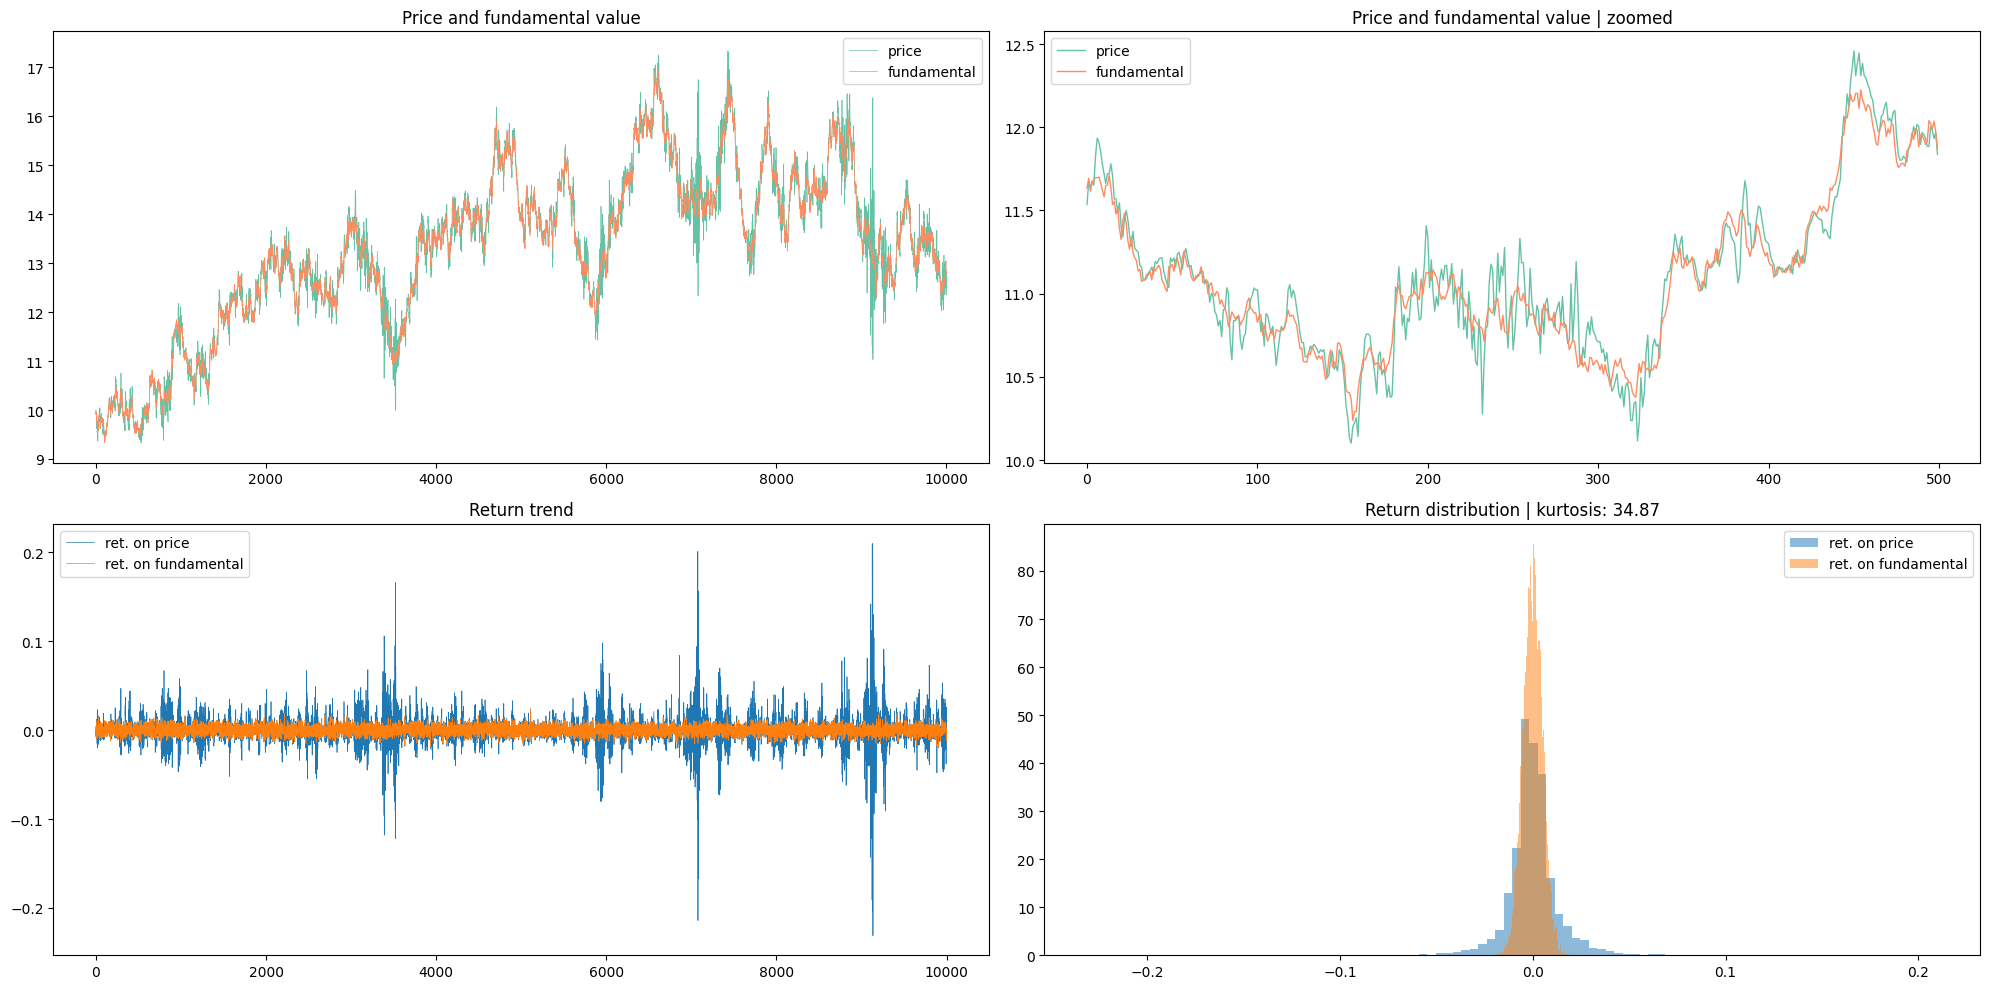

In [14]:
fig, ax = plt.subplots(2, 2, figsize=(20, 10))
colors = sns.color_palette("Set2", 2)

ax[0, 0].plot(time, history["prices"], lw=0.5, color=colors[0], label="price")
ax[0, 0].plot(time, history["fundamentals"], lw=0.5, color=colors[1], label="fundamental")
ax[0, 0].set_title("Price and fundamental value")
ax[0, 0].legend()

ax[0, 1].plot(history["prices"][1000:1500], lw=1, label="price", color=colors[0])
ax[0, 1].plot(history["fundamentals"][1000:1500], lw=1, label="fundamental", color=colors[1])
ax[0, 1].set_title("Price and fundamental value | zoomed")
ax[0, 1].legend()


ret = np.diff(np.log(history["prices"]))
eps = np.diff(np.log(history["fundamentals"]))
ax[1, 0].plot(ret, lw=0.5, label="ret. on price")
ax[1, 0].plot(eps, lw=0.5, label="ret. on fundamental")
ax[1, 0].set_title("Return trend")
ax[1, 0].legend()

ax[1, 1].set_title("Return distribution | kurtosis: {:.2f}".format(pd.Series(ret).kurtosis()))
ax[1, 1].hist(ret, bins=100, alpha=0.5, density=True, label="ret. on price")
ax[1, 1].hist(eps, bins=100, alpha=0.5, density=True, label="ret. on fundamental")
ax[1, 1].legend()

fig.tight_layout();

Text(0.5, 1.0, 'Return distribution')

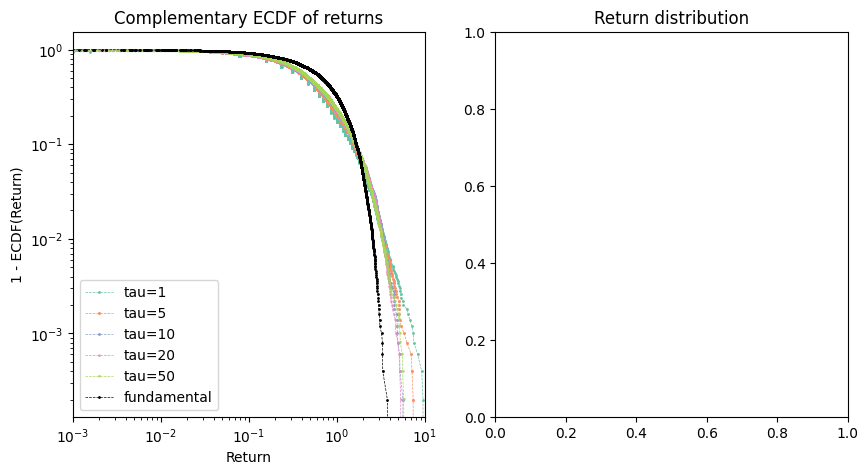

In [155]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
prices = history["prices"]
fundamentals = history["fundamentals"]

tau_list = [1, 5, 10, 20, 50]
markers = ["o", "s", "D", "^", "v"]
colors = sns.color_palette("Set2", len(tau_list))
for tau, marker, color in zip(tau_list, markers, colors):
    # Compute the return for the given tau
    ret = np.abs(computeReturns(prices, tau))
    
    # Compute the ECDF and plot the complement
    ecdf = ECDF(ret)
    ax[0].loglog(ecdf.x, 1-ecdf.y, label=f"tau={tau}", marker=marker, color=color, 
                 markersize=1, linestyle="--", linewidth=0.5)

ecdf_norm = ECDF(np.abs(computeReturns(fundamentals, 1)))
ax[0].loglog(ecdf_norm.x, 1-ecdf_norm.y, label="fundamental", marker="o", color="black", 
             markersize=1, linestyle="--", linewidth=0.5)
ax[0].legend()
ax[0].set_title("Complementary ECDF of returns")
ax[0].set_xlabel("Return")
ax[0].set_ylabel("1 - ECDF(Return)")
ax[0].set_xlim(1e-3, 10)

ax[1].set_title("Return distribution")


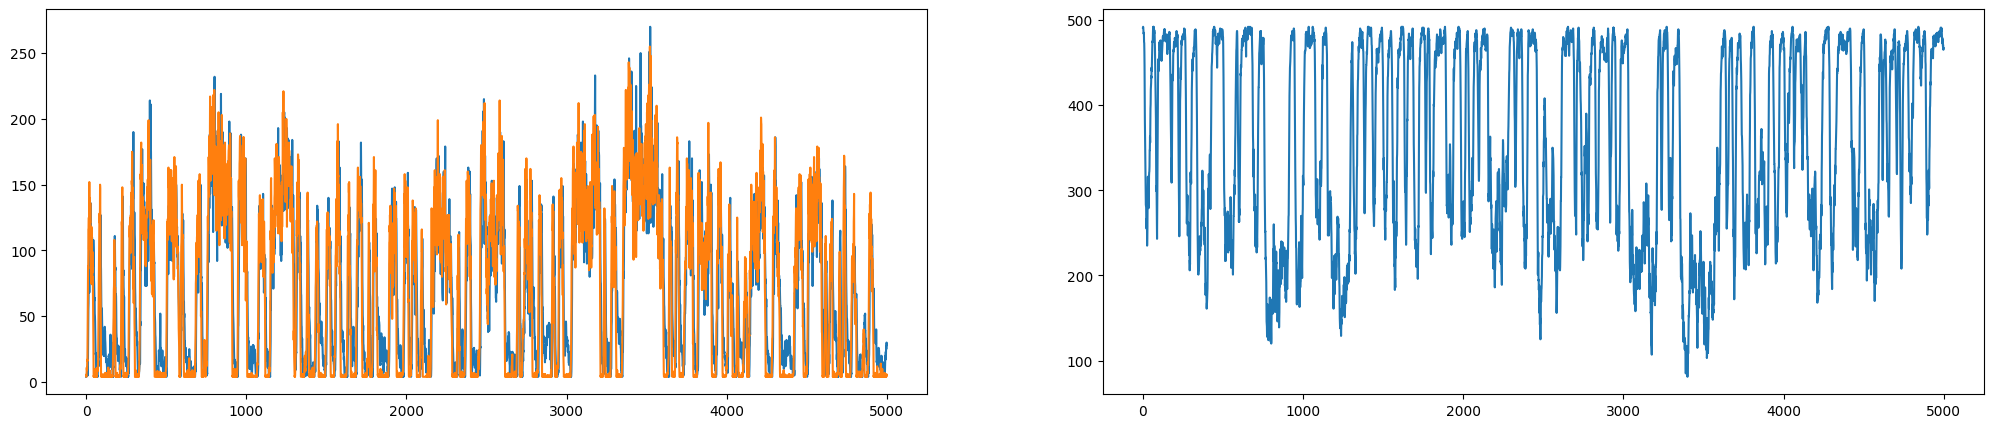

In [156]:
fig, ax = plt.subplots(1, 2, figsize=(25, 5))
N = state["n_p"] + state["n_m"] + state["n_f"]
ax[0].plot(history["optimists"])
ax[0].plot(history["pessimists"])
ax[1].plot(history["fundamentalists"])

In [181]:
def movingAverage(data, w):
    cumsum = np.cumsum(np.insert(data, 0, 0)) 
    avg = (cumsum[w:] - cumsum[:-w]) / float(w)
    return avg

def getFluctuations(data, t_values):
    assert np.max(t_values) < len(data)

    fluctuations = np.zeros(len(t_values))
    for i, t in enumerate(t_values):
        # Get the moving average
        local_trend = movingAverage(data, int(t))
        # Pad the data
        pad_size = len(data) - len(local_trend)
        local_trend_padded = np.pad(local_trend, (pad_size // 2, pad_size - pad_size // 2), mode='constant', constant_values=np.nan)
        # Compute the fluctuations
        fluctuations[i] = np.nanmean(np.abs(data - local_trend_padded))
    return fluctuations


[ 9.74727941  9.74197157  9.73657435 ... 14.79968033 14.78725728
 14.77002497]
[ 9.74452631  9.73908332  9.73336583 ... 14.80442317 14.79106693
 14.77904258]
[ 9.74164133  9.73588166  9.72985148 ... 14.80967429 14.79584772
 14.78289541]
[ 9.73844591  9.732377    9.72676989 ... 14.81437873 14.80113112
 14.78770913]
[ 9.7349503   9.72930076  9.723386   ... 14.81637075 14.80587247
 14.79301998]
[ 9.73187884  9.72592499  9.72069343 ... 14.81889908 14.80792652
 14.79779342]
[ 9.7285106   9.72323387  9.71814055 ... 14.8182855  14.81051066
 14.79990432]
[ 9.72582047  9.72068111  9.71652256 ... 14.81768449 14.80998121
 14.80253928]
[ 9.72326739  9.71905458  9.71493453 ... 14.81833042 14.80946266
 14.80208854]
[ 9.72163206  9.71745789  9.71311302 ... 14.81774178 14.81017809
 14.80164716]
[ 9.72002645  9.71563     9.71115143 ... 14.81783651 14.80966892
 14.80242713]
[ 9.71819189  9.7136634   9.70922493 ... 14.817264   14.80983553
 14.80199238]
[ 9.71621998  9.71173168  9.70767253 ... 14.81722997

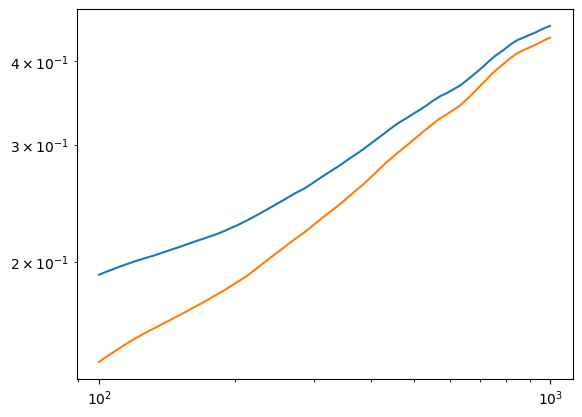

In [185]:
t_values = np.arange(1e2, 1e3, 1)
plt.plot(t_values, getFluctuations(history["prices"], t_values), label="price")
plt.plot(t_values, getFluctuations(history["fundamentals"], t_values), label="fundamental")
plt.xscale("log")
plt.yscale("log")